In [1]:
pip install numpy==1.26.4 torch transformers==4.48.2 scikit-learn accelerate==0.26.0 matplotlib tqdm pandas seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os, torch, numpy as np, glob
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === KONFIGURASI ====================================================================
DATA_DIR    = "/workspace/SPLIT_RHYTHM_NPY/train"
MODEL_BASE  = "/workspace/HASIL_BERT_RHYTHM_Default/HASIL_UjiCoba"
LABEL_MAP   = {'N': 0, 'AFIB': 1, 'VFL': 2}
MODEL_NAME  = "bert-base-uncased"
MAX_LEN     = 512
EPOCHS      = 2
BATCH_SIZE  = 16
SEED        = 42

os.makedirs(MODEL_BASE, exist_ok=True)
torch.manual_seed(SEED)
np.random.seed(SEED)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
cls_names = list(LABEL_MAP.keys())

# === Dataset Custom ==================================================================
class ECGDataset(Dataset):
    def __init__(self, files, labels):
        self.texts = [self.signal_to_text(np.load(f)) for f in files]
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=MAX_LEN, return_tensors='pt')
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    @staticmethod
    def signal_to_text(sig):
        norm = ((sig - sig.min()) / (sig.ptp() + 1e-8) * 255).astype(int)
        return " ".join(map(str, norm.tolist()))

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm.sum(axis=1) - np.diag(cm)
    fp = cm.sum(axis=0) - np.diag(cm)
    spec = tn / (tn + fp + 1e-8)
    return spec.mean()

# === Load Data =========================================================================
all_files, all_labels = [], []
for cls, idx in LABEL_MAP.items():
    files = glob.glob(os.path.join(DATA_DIR, cls, "*.npy"))
    all_files.extend(files)
    all_labels.extend([idx] * len(files))

all_labels = np.array(all_labels)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
final_summary = []

# === Training per Fold ==================================================================
for fold, (train_idx, val_idx) in enumerate(skf.split(all_files, all_labels), 1):
    print(f"\n==== Training Fold {fold} ====")

    train_files = [all_files[i] for i in train_idx]
    val_files   = [all_files[i] for i in val_idx]
    train_labels= all_labels[train_idx]
    val_labels  = all_labels[val_idx]

    train_dataset = ECGDataset(train_files, train_labels)
    val_dataset   = ECGDataset(val_files, val_labels)

    model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(LABEL_MAP))
    output_dir = os.path.join(MODEL_BASE, f"fold{fold}")
    os.makedirs(output_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        logging_dir=os.path.join(output_dir, "logs"),
        no_cuda=False,
        save_total_limit=1
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
    )

    # === Logging Manual ==================================================================
    history = {'epoch': [], 'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    for epoch in range(1, EPOCHS + 1):
        print(f"\n--- Epoch {epoch}/{EPOCHS} ---")
        trainer.train()

        train_pred = trainer.predict(train_dataset)
        train_preds = np.argmax(train_pred.predictions, axis=1)
        train_loss = train_pred.metrics['test_loss']
        train_acc = accuracy_score(train_labels, train_preds)

        val_pred = trainer.predict(val_dataset)
        val_preds = np.argmax(val_pred.predictions, axis=1)
        val_loss = val_pred.metrics['test_loss']
        val_acc = accuracy_score(val_labels, val_preds)

        val_recall = recall_score(val_labels, val_preds, average='macro')
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        val_spec = specificity_score(val_labels, val_preds)

        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Val Recall: {val_recall:.4f} | Val F1: {val_f1:.4f} | Val Specificity: {val_spec:.4f}")

    # === Simpan Visual dan Evaluasi Fold =================================================
    pd.DataFrame(history).to_csv(os.path.join(output_dir, f'history_fold{fold}.csv'), index=False)

    plt.plot(history['epoch'], history['train_loss'], label='Train Loss')
    plt.plot(history['epoch'], history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.title(f'Loss per Epoch Fold {fold}')
    plt.savefig(os.path.join(output_dir, f'loss_curve_fold{fold}.png')); plt.close()

    plt.plot(history['epoch'], history['train_acc'], label='Train Acc')
    plt.plot(history['epoch'], history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
    plt.title(f'Accuracy per Epoch Fold {fold}')
    plt.savefig(os.path.join(output_dir, f'acc_curve_fold{fold}.png')); plt.close()

    cm = confusion_matrix(val_labels, val_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cls_names, yticklabels=cls_names)
    plt.title(f'Confusion Matrix Fold {fold}'); plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'confusion_matrix_fold{fold}.png')); plt.close()

    report = classification_report(val_labels, val_preds, target_names=cls_names, output_dict=True)
    pd.DataFrame(report).T.to_csv(os.path.join(output_dir, f'classification_report_fold{fold}.csv'))

    final_summary.append({
        'fold': fold,
        'accuracy': val_acc,
        'recall': val_recall,
        'f1_score': val_f1,
        'specificity': val_spec
    })

    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"✅ Fold {fold} selesai. Model disimpan di {output_dir}")

# === Ringkasan Akhir ================================================================
pd.DataFrame(final_summary).to_csv(os.path.join(MODEL_BASE, 'final_summary.csv'), index=False)
print(f"\n✅ Semua fold selesai. Ringkasan akhir disimpan di {MODEL_BASE}/final_summary.csv")

RuntimeError: Failed to import transformers.models.bert.modeling_bert because of the following error (look up to see its traceback):
Failed to import transformers.integrations.peft because of the following error (look up to see its traceback):
Only a single TORCH_LIBRARY can be used to register the namespace c10d_functional; please put all of your definitions in a single TORCH_LIBRARY block.  If you were trying to specify implementations, consider using TORCH_LIBRARY_IMPL (which can be duplicated).  If you really intended to define operators for a single namespace in a distributed way, you can use TORCH_LIBRARY_FRAGMENT to explicitly indicate this.  Previous registration of TORCH_LIBRARY was registered at /dev/null:241; latest registration was registered at /dev/null:241

   Akurasi  Sensitivitas  Spesifisitas  F1-Score
0   0.9760        0.9680        0.9835    0.9644
  Kelas  Akurasi  Sensitivitas  Spesifisitas  F1-Score
0     N   0.9752        0.9640        0.9797    0.9624
1  AFIB   0.9785        0.9750        0.9822    0.9621
2   VFL   0.9743        0.9650        0.9885    0.9683


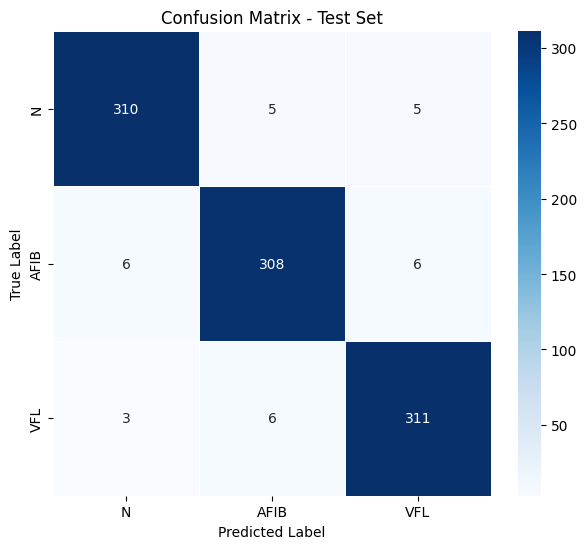

In [ ]:
import os, numpy as np, pandas as pd
import torch
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# === KONFIGURASI ===
MODEL_PATH = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_TRAIN\RYTHM\HASIL_BERT_RHYTHM_TUNED\HASIL_BERT_RHYTHM_TUNED\fold5"
TEST_DIR   = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\DATA_UJI_INFERENCE\RYTHMtest"
LABEL_MAP  = {'N': 0, 'AFIB': 1, 'VFL': 2}
IDX2LABEL  = {v: k for k, v in LABEL_MAP.items()}
MAX_LEN    = 512
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === LOAD TOKENIZER DAN MODEL ===
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
model = BertForSequenceClassification.from_pretrained(MODEL_PATH).to(DEVICE)
model.eval()

# === UTILS ===
def signal_to_text(sig, target_len=512):
    if len(sig) < target_len:
        pad = np.full(target_len - len(sig), sig[-1])
        sig = np.concatenate([sig, pad])
    else:
        idx = np.linspace(0, len(sig) - 1, target_len).astype(int)
        sig = sig[idx]
    norm = ((sig - sig.min()) / (sig.ptp() + 1e-8) * 255).astype(int)
    return " ".join(map(str, norm))

def load_test_data(test_dir):
    data, labels = [], []
    for label_name in os.listdir(test_dir):
        folder_path = os.path.join(test_dir, label_name)
        if label_name not in LABEL_MAP:
            continue
        for file in os.listdir(folder_path):
            if file.endswith(".npy"):
                sig = np.load(os.path.join(folder_path, file), allow_pickle=True)
                if isinstance(sig, np.ndarray) and sig.ndim == 1:
                    data.append(signal_to_text(sig))
                    labels.append(LABEL_MAP[label_name])
    return data, np.array(labels)

# === LOAD DATA TEST ===
texts, y_true = load_test_data(TEST_DIR)

# === INFERENSI ===
preds = []
batch_size = 32
for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]
    encodings = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())

# === EVALUASI GLOBAL ===
acc  = accuracy_score(y_true, preds)
rec  = recall_score(y_true, preds, average='macro', zero_division=0)
f1   = f1_score(y_true, preds, average='macro', zero_division=0)
cm   = confusion_matrix(y_true, preds)

def specificity_per_class(true, pred, label, num_classes):
    cm = confusion_matrix(true, pred, labels=list(range(num_classes)))
    TN = cm.sum() - (cm[label, :].sum() + cm[:, label].sum() - cm[label, label])
    FP = cm[:, label].sum() - cm[label, label]
    return TN / (TN + FP + 1e-8)

spec = np.mean([specificity_per_class(y_true, preds, i, len(LABEL_MAP)) for i in range(len(LABEL_MAP))])

# === CETAK METRIK GLOBAL ===
print(f"\n=== Evaluasi Model BERT Base (Best Model Fold 5) ===")
print(f"Akurasi     : {acc:.4f}")
print(f"Recall      : {rec:.4f}")
print(f"F1-score    : {f1:.4f}")
print(f"Spesifisitas: {spec:.4f}")

# === CONFUSION MATRIX ===
plt.figure(figsize=(6,6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                 xticklabels=LABEL_MAP.keys(),
                 yticklabels=LABEL_MAP.keys(), cbar=False)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j + 0.5, i + 0.5, format(cm[i, j], 'd'),
                ha='center', va='center',
                color='white' if i == j else 'black',
                fontsize=10)

plt.title("Confusion Matrix - BERT Base Rhythm (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, "confmat_test.png"))
plt.show()

# === METRIK PER KELAS ===
cls_names = list(LABEL_MAP.keys())
cm = confusion_matrix(y_true, preds, labels=list(range(len(cls_names))))
per_class_metrics = defaultdict(dict)

for i, cls in enumerate(cls_names):
    TP = cm[i, i]
    FN = cm[i].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)

    acc_cls  = (TP + TN) / cm.sum()
    rec_cls  = TP / (TP + FN + 1e-8)
    spec_cls = TN / (TN + FP + 1e-8)
    f1_cls   = f1_score(y_true, preds, labels=[i], average='macro', zero_division=0)

    per_class_metrics[cls]["Accuracy"]     = round(acc_cls, 4)
    per_class_metrics[cls]["Recall"]       = round(rec_cls, 4)
    per_class_metrics[cls]["Specificity"]  = round(spec_cls, 4)
    per_class_metrics[cls]["F1-Score"]     = round(f1_cls, 4)

# === TABEL PER KELAS ===
df_per_class = pd.DataFrame(per_class_metrics).T
print("\n=== Metrik Per Kelas ===")
print(df_per_class)

# === SIMPAN ===
df_per_class.to_csv(os.path.join(MODEL_PATH, "test_metrics_perclass.csv"))